Actor Critic, updated implementation, with tensors - working backwards from A2C implementation

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from dataclasses import dataclass, asdict

import plot
from session_tracker import SessionTracker

import modal

In [28]:
app = modal.App(name='rl')

image = modal.Image.debian_slim()\
    .apt_install('swig', 'build-essential')\
        .pip_install("gymnasium", "torch", "gymnasium[box2d]", "numpy", "stable_baselines3")\
        .add_local_python_source('session_tracker')

In [29]:
class ActorCriticAgent(nn.Module):
    def __init__(self, state_space, action_space, hidden_size=64):
        super(ActorCriticAgent, self).__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.fc1 = nn.Linear(state_space, hidden_size)

        self.actor_head = nn.Linear(hidden_size, action_space)
        self.critic_head = nn.Linear(hidden_size, 1)
    
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        actor_logits = self.actor_head(x)
        critic_value = self.critic_head(x)

        return actor_logits, critic_value
    
    # states (n_envs, n_obs)
    def get_action(self, states):
        # Get the raw output from the network (logits)
        actor_logits, critic_values = self.forward(states)
        
        # Turn logits into probabilities and create a distribution
        # Categorical is useful for discrete action spaces (like Lunar Lander)
        action_distributions = Categorical(logits=actor_logits)
        
        # Sample an action from the distribution
        actions = action_distributions.sample()
        
        # Get the log probability of the chosen action
        log_probs = action_distributions.log_prob(actions)
        log_probs = log_probs.unsqueeze(-1)  # Ensure log_probs has shape (n_envs, 1)
        actions = actions.unsqueeze(-1)  # Ensure actions has shape (n_envs, 1)
        
        # Return the action and its log-probability
        return actions, log_probs, critic_values

In [30]:
@dataclass
class ACParams:
    gamma: float            = 0.99
    normalize_returns: bool = True
    lr: float               = 0.001

In [31]:
@dataclass
class RolloutData:
    # obs: torch.Tensor
    # actions: torch.Tensor
    log_probs: torch.Tensor
    values: torch.Tensor
    rewards: torch.Tensor
    # dones: torch.Tensor

In [50]:
def collect_data_for_rollout(env, network, tracker):
    """
    Collect experiences by running the policy in the environment
    """

    n_envs = 1
    n_obs = env.observation_space.shape[0]
    
    rollout_log_probs_t = torch.zeros((n_envs, 0, 1)) # (n_envs, n_steps, 1)
    rollout_values_t = torch.zeros((n_envs, 0, 1)) # (n_envs, n_steps, 1)
    rollout_rewards_t = torch.zeros((n_envs, 0, 1)) # (n_envs, n_steps, 1)

    current_obs, _ = env.reset()

    while not tracker.session_complete():
        tracker.increment_timestep(n=n_envs)
        
        obs_t = torch.tensor(current_obs, dtype=torch.float32) # (n_envs, n_obs)
        action_t, log_prob_t, value_t = network.get_action(obs_t)

        action = action_t.squeeze().numpy()  # Convert to numpy for envs.step. t(n_envs, 1) -> np(n_envs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        log_prob_t = log_prob_t.view(n_envs, 1, 1) # (n_envs) -> (n_envs, 1 step, 1 value)
        rollout_log_probs_t = torch.cat((rollout_log_probs_t, log_prob_t), dim=1)  # (n_envs, n_steps, 1)

        value_t = value_t.view(n_envs, 1, 1)  # (n_envs) -> (n_envs, 1 step, 1 value)
        rollout_values_t = torch.cat((rollout_values_t, value_t), dim=1)  # (n_envs, n_steps, 1)

        reward_t = torch.tensor(reward, dtype=torch.float32).view(n_envs, 1, 1)  # () -> (n_envs, 1 step, 1 value)
        rollout_rewards_t = torch.cat((rollout_rewards_t, reward_t), dim=1)  # (n_envs, n_steps, 1)

        if terminated or truncated:
            episode_return = info['episode']['r']
            episode_length = info['episode']['l']

            tracker.log_finished_episode(episode_return, episode_length)
            break

        # update the obs to the result of the step
        current_obs = next_obs

    rollout_data = RolloutData(
        log_probs=rollout_log_probs_t,
        values=rollout_values_t,
        rewards=rollout_rewards_t,
    )
    
    return rollout_data

In [53]:
torch.manual_seed(0)
np.random.seed(0)

env = gym.make('LunarLander-v3')
env = gym.wrappers.RecordEpisodeStatistics(env)
current_obs, _ = env.reset(seed=0)

network = ActorCriticAgent(
    state_space=env.observation_space.shape[0],
    action_space=env.action_space.n)

tracker = SessionTracker(n_timesteps=100000, print_interval=None, window_length=64)

rollout_data = collect_data_for_rollout(env, network, tracker)

# rollout_data.log_probs

In [54]:
def calculate_returns(rewards, gamma=0.99, normalize_returns=True):
    n_envs = 1

    all_returns = torch.zeros_like(rewards) # (n_envs, n_steps, 1)

    current_return = torch.zeros((n_envs, 1, 1))  # (n_envs, 1, 1)

    for t in range(rewards.shape[1] - 1, -1, -1):
        current_reward = rewards[:, t, :]
        current_return = current_reward + (gamma * current_return)
        all_returns[:, t, :] = current_return

    if normalize_returns:
        all_returns = (all_returns - all_returns.mean()) / (all_returns.std() + 1e-9)

    return all_returns

In [17]:
env = gym.make('CartPole-v1')
env = gym.wrappers.RecordEpisodeStatistics(env)

current_obs, _ = env.reset()

network = ActorCriticAgent(
    state_space=env.observation_space.shape[0],
    action_space=env.action_space.n)

tracker = SessionTracker(n_timesteps=100000, print_interval=None, window_length=64)

rollout_data = collect_data_for_rollout(env, network, tracker)

returns = calculate_returns(rollout_data.rewards, gamma=1.0, normalize_returns=False)

In [34]:
def train_actor_critic(agent, env_name, n_timesteps=100000, params=None):
    if params is None:
        params = ACParams()

    tracker = SessionTracker(n_timesteps=n_timesteps, print_interval=10000, window_length=64)

    env = gym.make(env_name)
    env = gym.wrappers.RecordEpisodeStatistics(env)

    optimizer = optim.Adam(agent.parameters(), lr=params.lr)

    while not tracker.session_complete():
        rollout_data = collect_data_for_rollout(env, agent, tracker=tracker)
        
        returns = calculate_returns(rollout_data.rewards, gamma=params.gamma, normalize_returns=params.normalize_returns)
        
        # --- Critic Loss ---
        # The critic is trained using Mean Squared Error (MSE) between its predicted values
        # and the actual discounted returns (targets).
        # We want the critic to be good at predicting the true value of a state.
        critic_loss = nn.MSELoss()(rollout_data.values, returns)

        # --- Calculate Advantage ---
        # This is the key difference from REINFORCE.
        # Advantage = Actual_Return - Critic_Predicted_Value
        # It tells us how much better (or worse) the observed outcome was than what the critic expected.
        advantage = returns - rollout_data.values.detach() # .detach() is important!
        
        # # Explanation of .detach():
        # # We detach the critic_values here because we *only* want the actor's loss
        # # to influence the actor's part of the network through the log_probs.
        # # We don't want the advantage calculation to "backpropagate" through the critic network
        # # when we're calculating the actor's loss. The critic has its own separate loss (critic_loss)
        # # that handles its updates. If we didn't detach, the actor's loss would try to pull the
        # # critic's weights in a way that might not be optimal for the critic's value prediction task.

        # # # Advantage normalization
        # advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)

        # # --- Actor Loss ---
        # # The actor's loss is now based on the advantage.
        # # We want to increase the probability of actions that led to a positive advantage
        # # and decrease the probability of actions that led to a negative advantage.
        actor_loss = - (rollout_data.log_probs * advantage).sum()

        # # --- Total Loss and Optimization ---
        # # The total loss combines both the critic's and actor's objectives.
        # # We generally add them together. The relative weighting can sometimes be tuned,
        # # but a simple sum is a good starting point.
        total_loss = critic_loss + actor_loss

        optimizer.zero_grad() # Clear any old gradients
        total_loss.backward() # Calculate gradients for both losses
        # # torch.nn.utils.clip_grad_norm_(agent.parameters(), max_norm=0.5)
        optimizer.step()      # Update the network weights

    env.close()

    return tracker.all_returns, tracker.all_lengths

In [55]:
torch.manual_seed(0)
np.random.seed(0)

env_name = 'LunarLander-v3'
env = gym.make(env_name)

n_timesteps = 400000

params = ACParams(gamma=0.99, normalize_returns=True, lr=0.001)

agent = ActorCriticAgent(
    state_space=env.observation_space.shape[0],
    action_space=env.action_space.n)

returns, lengths = train_actor_critic(agent, env_name, n_timesteps=n_timesteps, params=params)

Current timestep: 10000, recent mean: -160.34, recent length: 99.95, (window: 64)


KeyboardInterrupt: 

(498,) (498,)


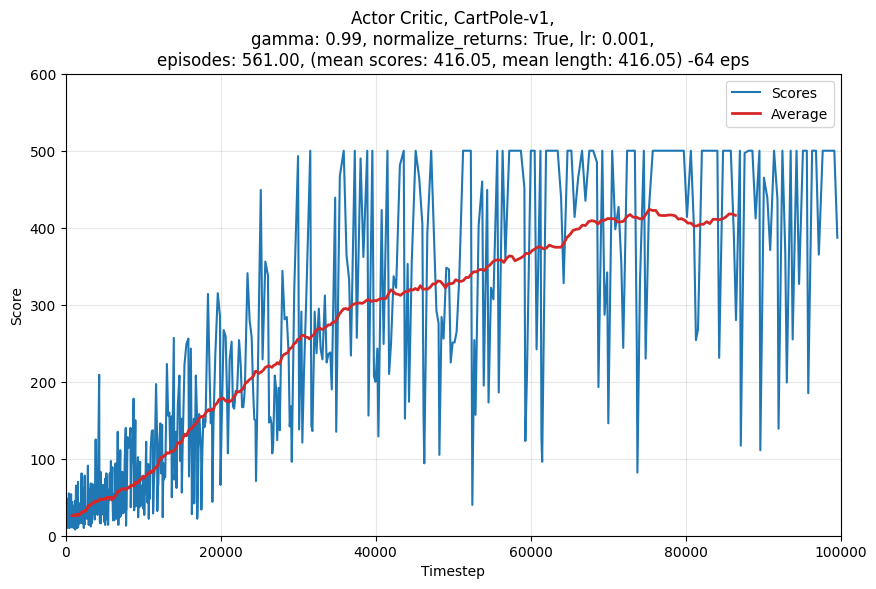

In [19]:
plot.plot_session(returns, lengths, 'Actor Critic', env_name, n_timesteps, params=asdict(params))

In [56]:
@app.function(image=image, timeout=3600)
def modal_train_actor_critic(env_name, n_timesteps, params=None):
    agent = ActorCriticAgent(state_space=gym.make(env_name).observation_space.shape[0],
                          action_space=gym.make(env_name).action_space.n)
    
    returns, lengths = train_actor_critic(
        agent, env_name, n_timesteps=n_timesteps, params=params)
    return returns, lengths

In [ ]:
n_sessions = 16
env_name = 'CartPole-v1'
n_timesteps = 100000
params = ACParams(gamma=0.99, normalize_returns=True, lr=0.001)

with app.run():
    calls = [modal_train_actor_critic.spawn(
        env_name=env_name, n_timesteps=n_timesteps, params=params)
        for i in range(n_sessions)]

    results = modal.FunctionCall.gather(*calls)

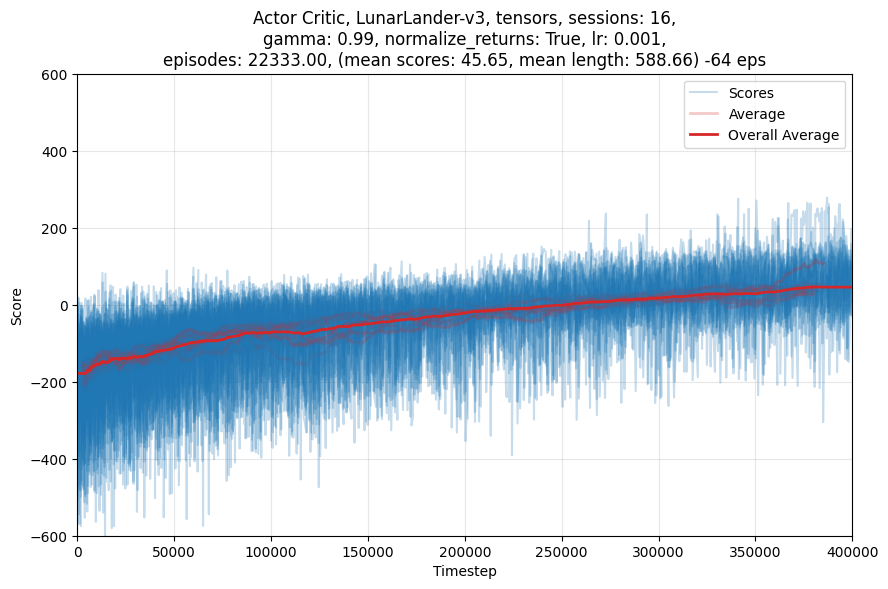

In [58]:
plot.plot_sessions(results, 'Actor Critic', env_name, n_timesteps, method_title='tensors', params=asdict(params))